# 0.0. Imports

In [29]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb

from boruta import BorutaPy
from matplotlib import pyplot as plt
from IPython.display import HTML

from sklearn import model_selection as ms
from sklearn import neighbors as ng
from sklearn import linear_model as lm
from sklearn import ensemble as en
from sklearn import preprocessing as pp

## 0.1. Helper Functions

In [3]:
def precision_at_k(data, k):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return (data.loc[k, 'precision_at_k'], data)


def recall_at_k( data, k ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return ( data.loc[ k, 'recall_at_k'], data )


def perfomance_metrics_at_k(x_val, y_val, yhat, model_name, percentage_of_base):  
    df = x_val.copy()
    df['response'] = y_val
    df['score'] = yhat[:, 1].tolist()
    df = df.sort_values( 'score', ascending=False )

    k = int(percentage_of_base * df.shape[0])

    precision,  data = precision_at_k(df, k)
    recall, data = recall_at_k(df, k)

    return pd.DataFrame({'model_name': [model_name],
                         'Precision@K': [round(precision, 3)],
                         'Recall@K': [round(recall, 3)]}, index=[0])

def descriptive_statistics(num_attributes):
    # ct: mean, median
    ct1 = pd.DataFrame(num_attributes.apply(np.mean))
    ct2 = pd.DataFrame(num_attributes.apply(np.median))

    # dispersion: min, max, range, std, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.min))
    d2 = pd.DataFrame(num_attributes.apply(np.max))
    d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() ))
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.std() ))
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() ))
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() ))

    # concat
    m = pd.concat([d1,d2,d3,ct1,ct2,d4,d5,d6], axis=1).reset_index()
    m.columns = ['atributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
    return m

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [5]:
df_raw = pd.read_csv('../data/raw/train.csv')

# 1.0. Data Description

In [6]:
df1 = df_raw.copy()

*  **Id:** identificador único do cliente.
*  **Gender:** gênero do cliente.
*  **Age:** idade do cliente.
*  **Driving License:** 0, o cliente não tem permissão para dirigir e 1, o cliente tem para dirigir ( CNH – Carteira Nacional de Habilitação )
*  **Region Code:** código da região do cliente.
*  **Previously Insured:** 0, o cliente não tem seguro de automóvel e 1, o cliente já tem seguro de automóvel.
*  **Vehicle Age:** idade do veículo.
*  **Vehicle Damage:** 0, cliente nunca teve seu veículo danificado no passado e 1, cliente já teve seu veículo danificado no passado.
*  **Anual Premium:** quantidade que o cliente pagou à empresa pelo seguro de saúde anual.
*  **Policy sales channel:** código anônimo para o canal de contato com o cliente.
*  **Vintage:** número de dias que o cliente se associou à empresa através da compra do seguro de saúde.
*  **Response:** 0, o cliente não tem interesse e 1, o cliente tem interesse.

## 1.1. Rename Columns

In [7]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']
df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print(f'Number Of Rows: {df1.shape[0]}')
print(f'Number Of Columns: {df1.shape[1]}')

Number Of Rows: 381109
Number Of Columns: 12


## 1.3. Data Types

In [9]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5. Statistical Descriptive

In [11]:
num_atr = df1.select_dtypes(include=['int64', 'float64'])
cat_atr = df1.select_dtypes(include=['object'])

### 1.5.1. Numerical Attributes

In [12]:
descriptive_statistics(num_atr)

,atributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.836208,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511611,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046110,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229888,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.155057,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203995,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671304,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327936,2.301906e+00,3.298788


### 1.5.2. Categorical Attributes

In [13]:
columns = ['gender', 'vehicle_age', 'vehicle_damage', 'driving_license', 'response', 'previously_insured']
for column in columns:
    print(f'[ {column} ]: ')
    display(df1[column].value_counts(normalize=True))

[ gender ]: 


Male      0.540761
Female    0.459239
Name: gender, dtype: float64

[ vehicle_age ]: 


1-2 Year     0.525613
< 1 Year     0.432385
> 2 Years    0.042001
Name: vehicle_age, dtype: float64

[ vehicle_damage ]: 


Yes    0.504877
No     0.495123
Name: vehicle_damage, dtype: float64

[ driving_license ]: 


1    0.997869
0    0.002131
Name: driving_license, dtype: float64

[ response ]: 


0    0.877437
1    0.122563
Name: response, dtype: float64

[ previously_insured ]: 


0    0.54179
1    0.45821
Name: previously_insured, dtype: float64

# 2.0. Feature Engineering

In [14]:
df2 = df1.copy()

## 2.1. Feature Creation

In [15]:
# gender
gender_map = {'Male': 1, 'Female': 0}
df2.loc[:, 'gender'] = df2['gender'].map(gender_map)

# vehicle_age
vehicle_age_map = {'1-2 Year': 'between_1_2_years', '< 1 Year': 'bellow_1_year', '> 2 Years': 'over_2_year'}
df2.loc[:, 'vehicle_age'] = df2['vehicle_age'].map(vehicle_age_map)

# vehicle_damage
vehicle_damage_map = {'Yes': 1, 'No': 0}
df2.loc[:, 'vehicle_damage'] = df2['vehicle_damage'].map(vehicle_damage_map)

# 3.0. Data Filtering

In [16]:
df3 = df2.copy()

# 4.0. EDA

In [17]:
df4 = df3.copy()

## 4.1. Univariate Analysis

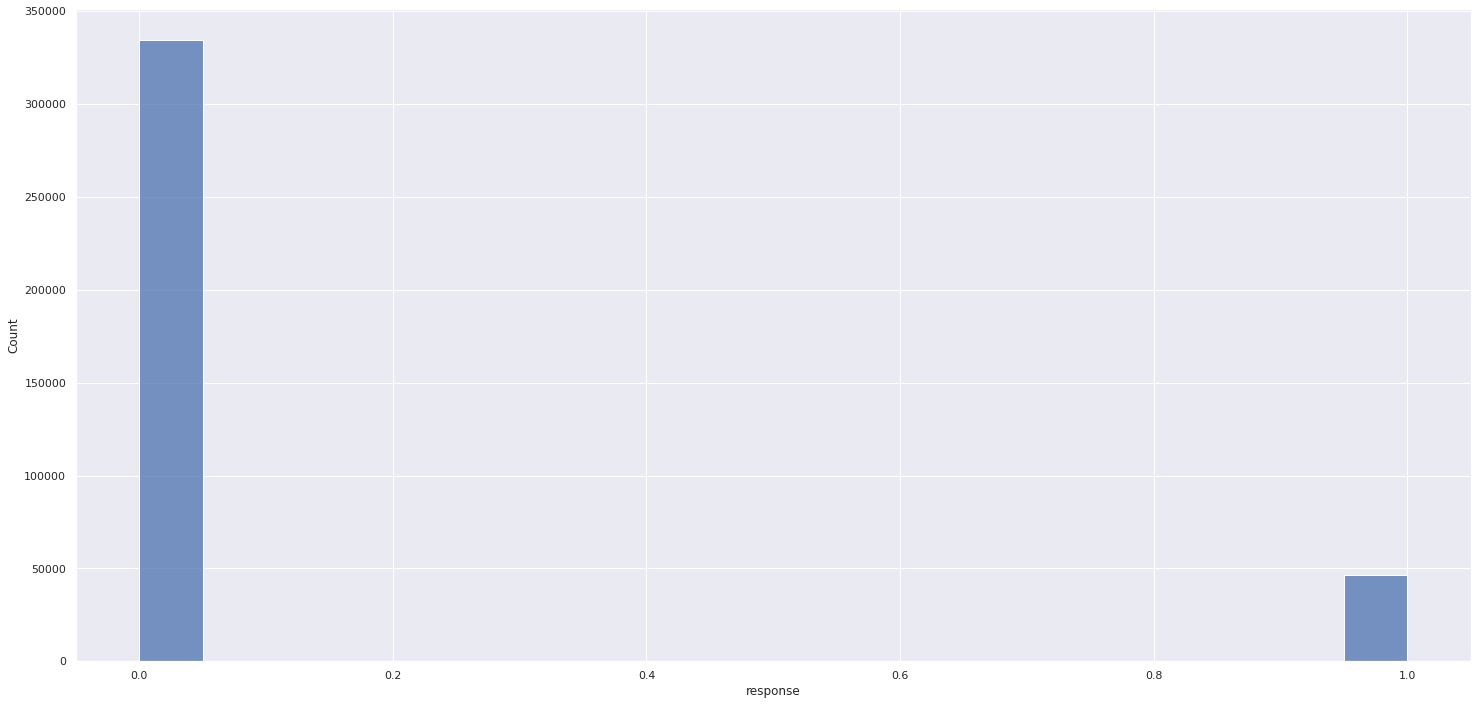

In [17]:
sns.histplot(df4['response']);

<AxesSubplot:xlabel='policy_sales_channel', ylabel='Count'>

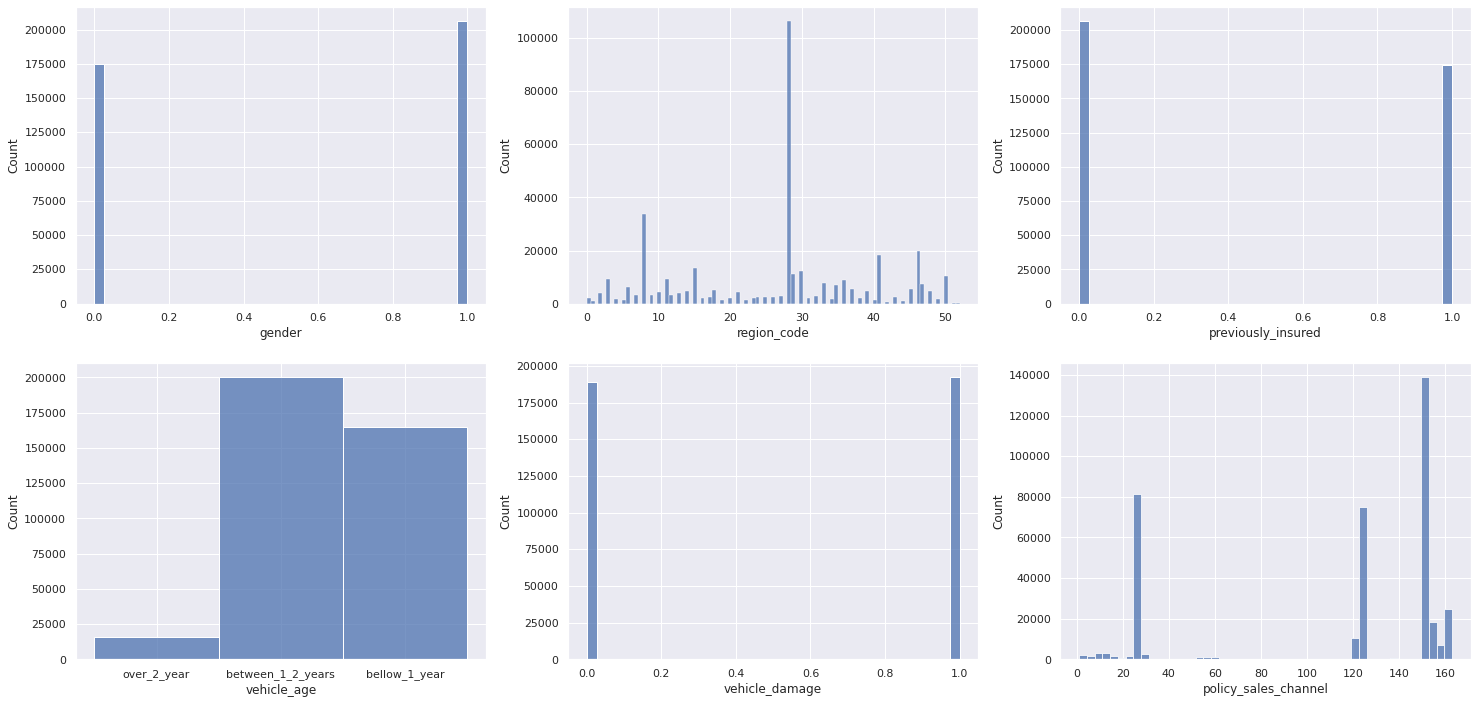

In [18]:
plt.subplot(2,3,1)
sns.histplot(df4['gender'])

plt.subplot(2,3,2)
sns.histplot(df4['region_code'])

plt.subplot(2,3,3)
sns.histplot(df4['previously_insured'])

plt.subplot(2,3,4)
sns.histplot(df4['vehicle_age'])

plt.subplot(2,3,5)
sns.histplot(df4['vehicle_damage'])

plt.subplot(2,3,6)
sns.histplot(df4['policy_sales_channel'])

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

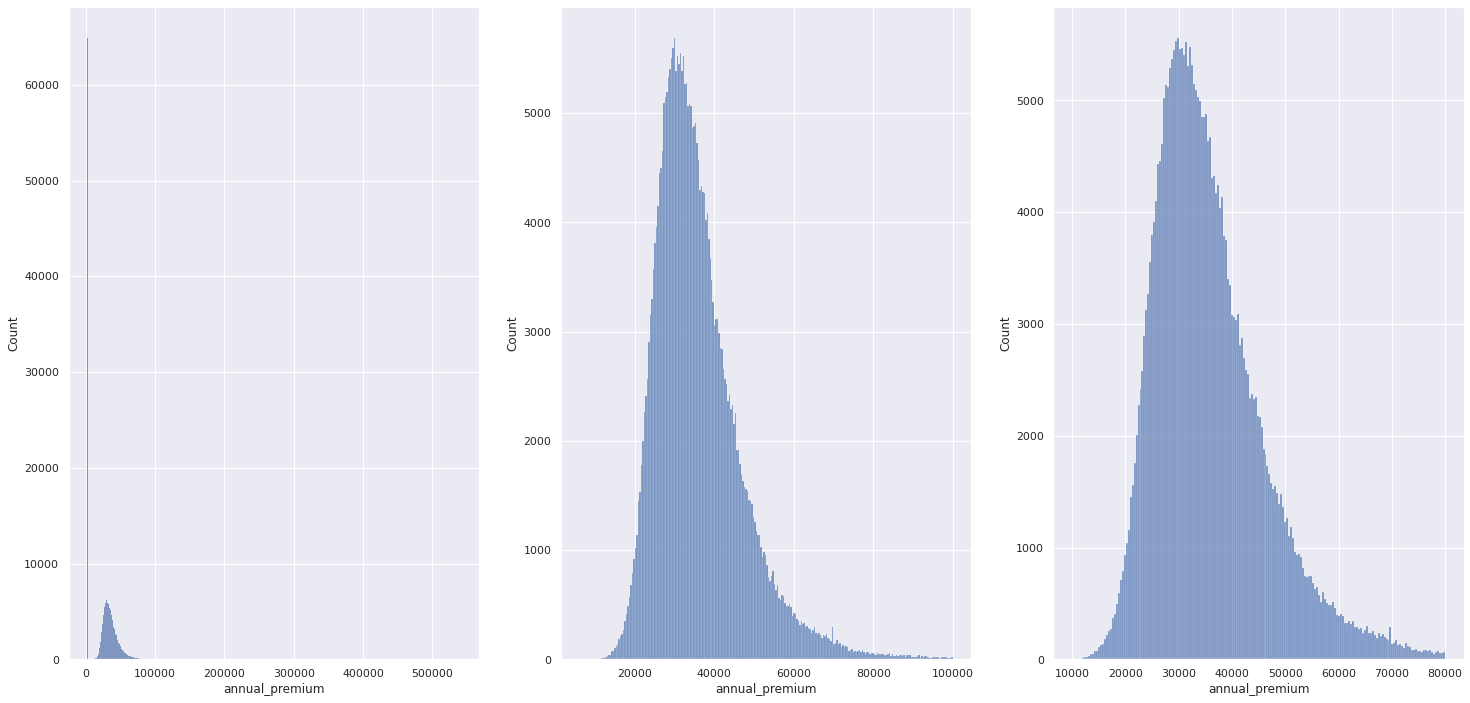

In [19]:
plt.subplot(1,3,1)
sns.histplot(df4['annual_premium'])

plt.subplot(1,3,2)
aux1 = df4[(df4['annual_premium'] > 3000.0) & (df4['annual_premium'] <= 100000.0)].copy()
sns.histplot(aux1['annual_premium'])

plt.subplot(1,3,3)
aux2 = df4[(df4['annual_premium'] > 10000.0) & (df4['annual_premium'] <= 80000.0)].copy()
sns.histplot(aux2['annual_premium'])

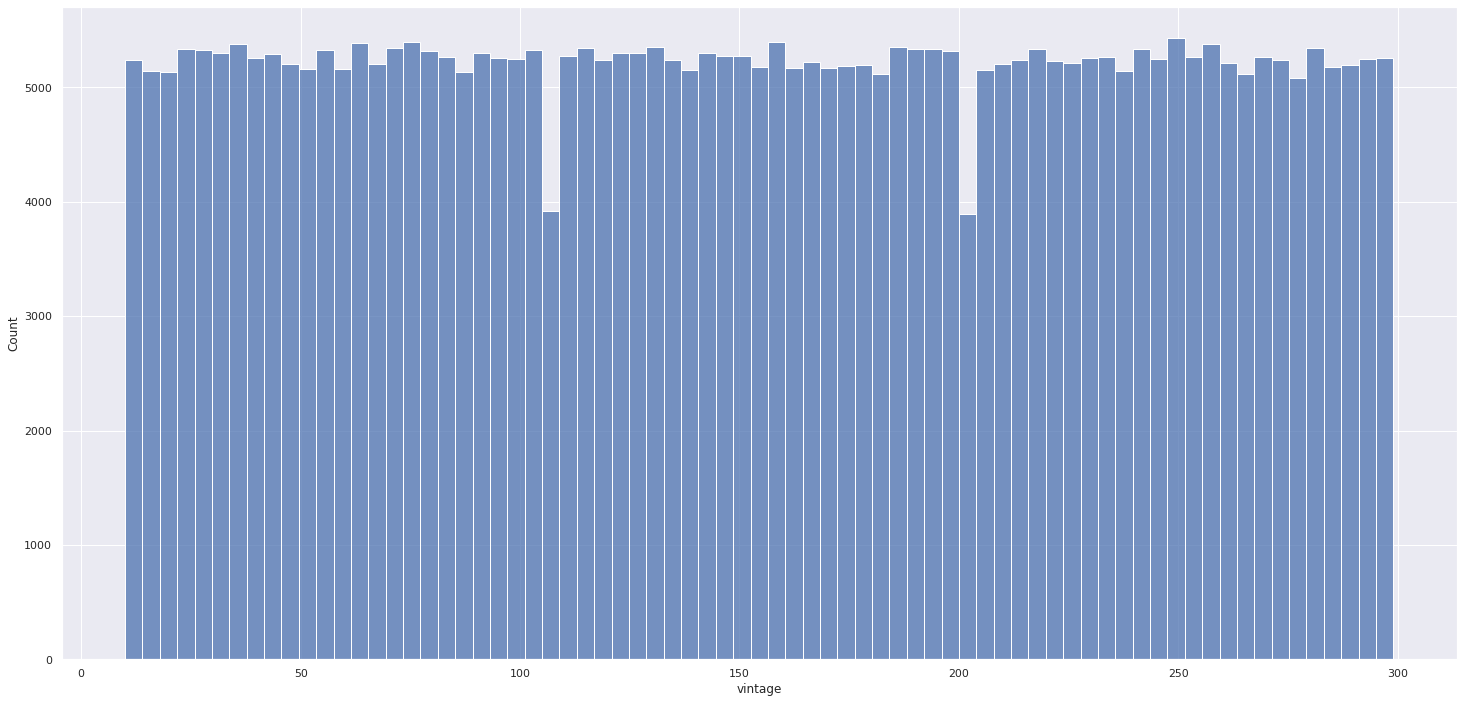

In [20]:
sns.histplot(df4['vintage']);

## 4.2. Bivariave Analysis

 ## Hipóteses

* **Gender:** Mulheres têm mais interesse em adquirir o seguro que homens
* **Age:** Pessoas acima de 40 anos tem mais interesse em adquirir o seguro
* **Driving License:** Pessoas com habilitação tem mais interesse em adquirir o seguro.
* **Region Code:** - 
* **Previously Insured:** Cliente que já tem seguro de automóveis tem mais interesse em migrar para o novo.
* **Vehicle Age:** Donos de veículos mais antigos, têm menos interesse em adquirir o seguro.
* **Vehicle Damage:** Pessoas que já tiveram seu veículo danificado, têm mais interesse em adquirir o seguro.
* **Anual Premium:** Quanto maior o valor do prêmio, mais interesse em adquirir o seguro.
* **Policy sales channel:** - 
* **Vintage:** -

### 4.2.1 gender vs response



<AxesSubplot:xlabel='gender', ylabel='response'>

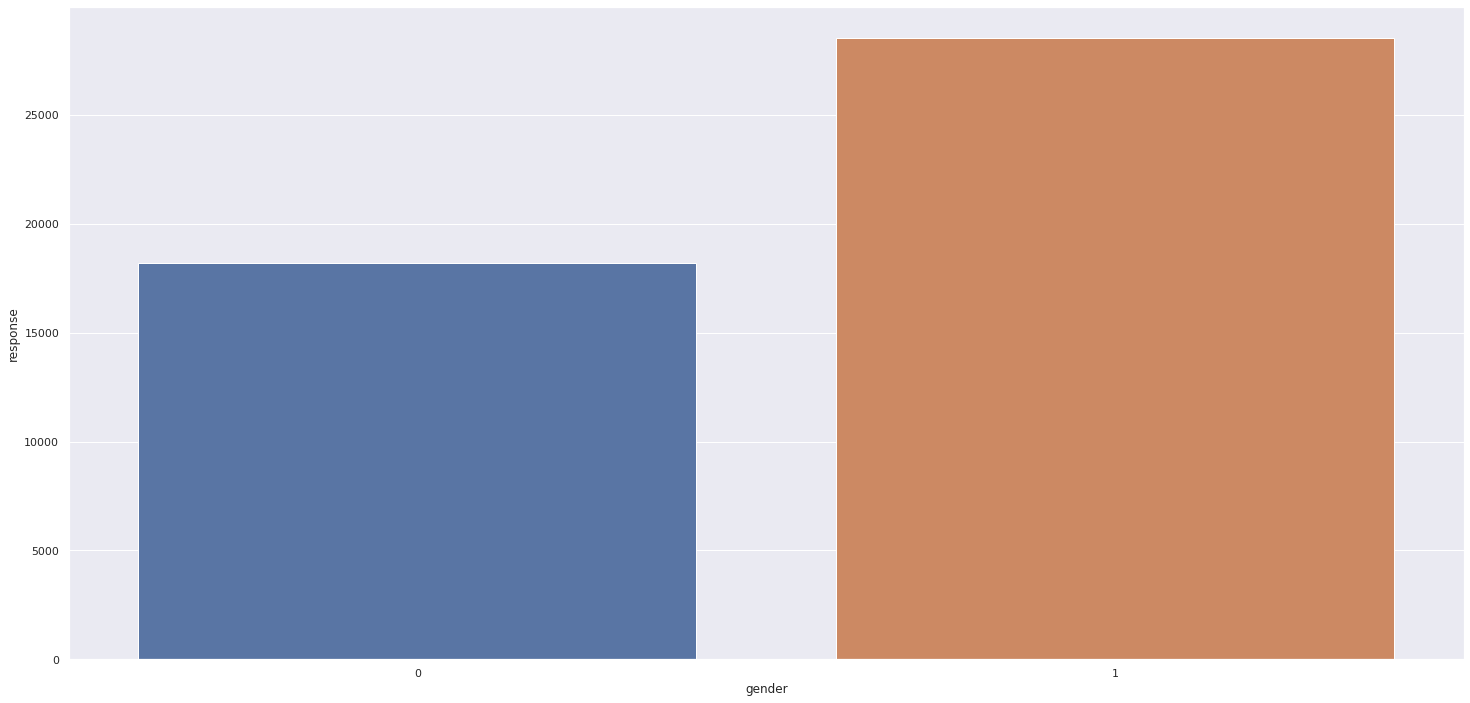

In [21]:
aux1 = df4[['gender', 'response']].groupby('gender').sum().reset_index()
sns.barplot(x='gender', y='response', data=aux1)

### 4.2.2 age vs response



<AxesSubplot:xlabel='response', ylabel='age'>

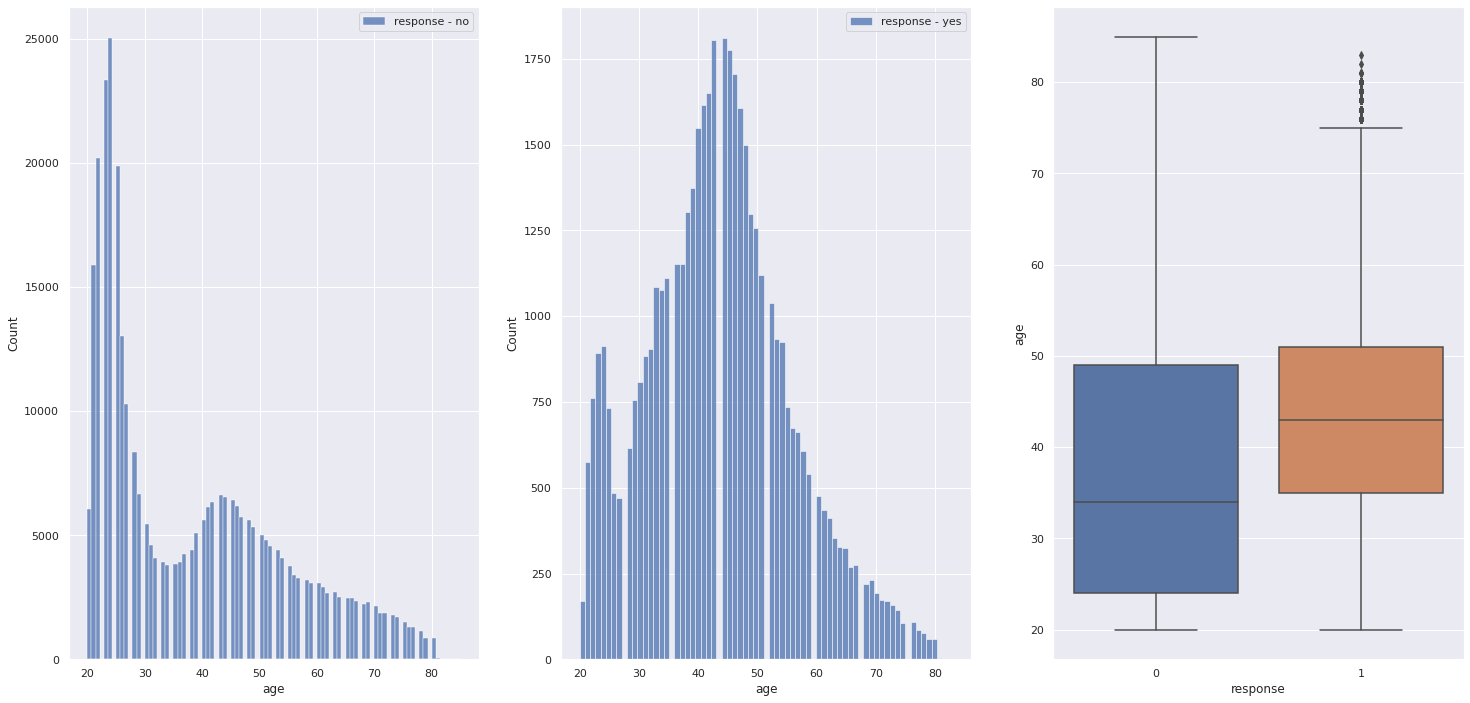

In [22]:
plt.subplot(1,3,1)
aux1 = df4[df4['response'] == 0]
sns.histplot(aux1['age'], label='response - no')
plt.legend()

plt.subplot(1,3,2)
aux2 = df4[df4['response'] == 1]
sns.histplot(aux2['age'], label='response - yes')
plt.legend()

plt.subplot(1,3,3)
sns.boxplot(x='response', y='age', data=df4)

### 4.2.3 Anual Premium vs response



<AxesSubplot:xlabel='response', ylabel='annual_premium'>

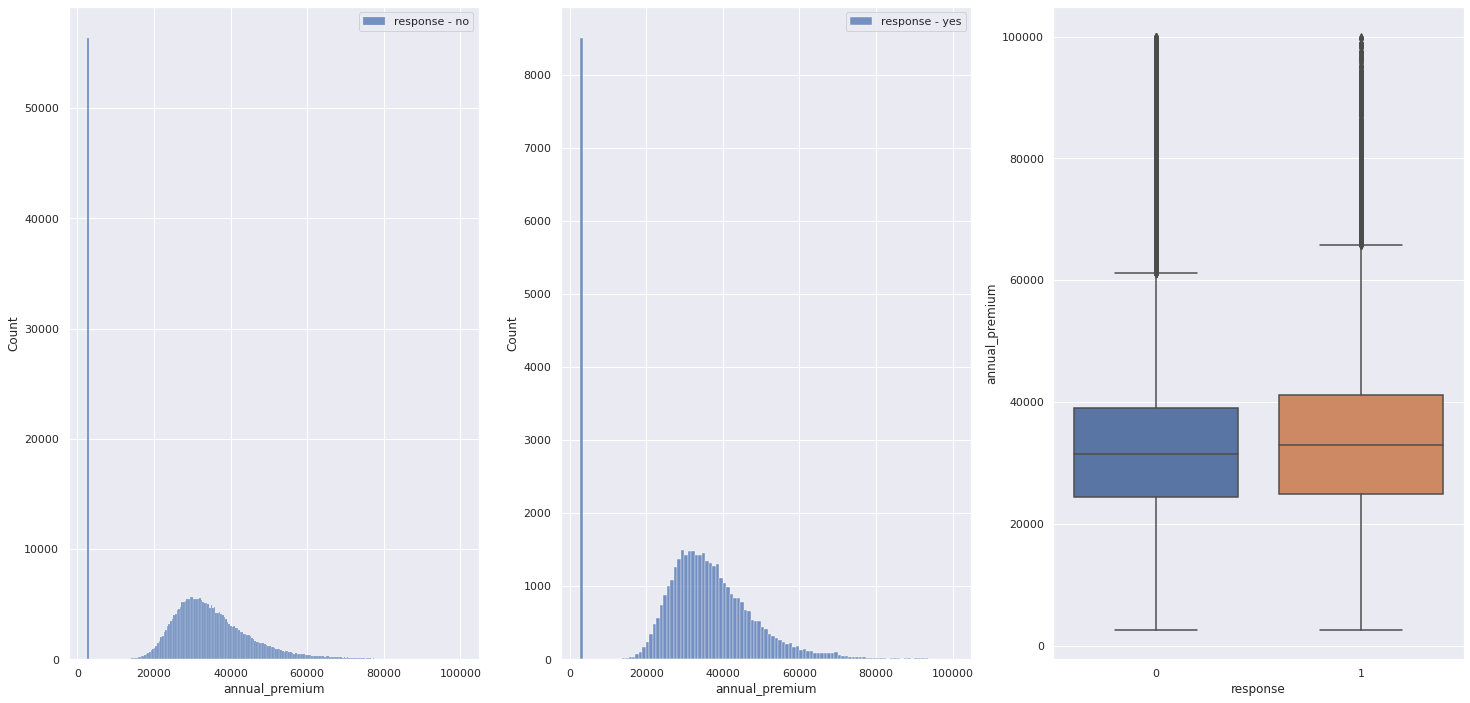

In [23]:
aux = df4[(df4['annual_premium'] >= 2000) & (df4['annual_premium'] <= 100000)]

plt.subplot(1,3,1)
aux1 = aux[aux['response'] == 0]
sns.histplot(aux1['annual_premium'], label='response - no')
plt.legend()

plt.subplot(1,3,2)
aux2 = aux[aux['response'] == 1]
sns.histplot(aux2['annual_premium'], label='response - yes')
plt.legend()

plt.subplot(1,3,3)
sns.boxplot(x='response', y='annual_premium', data=aux)

### 4.2.4. Driving License vs response



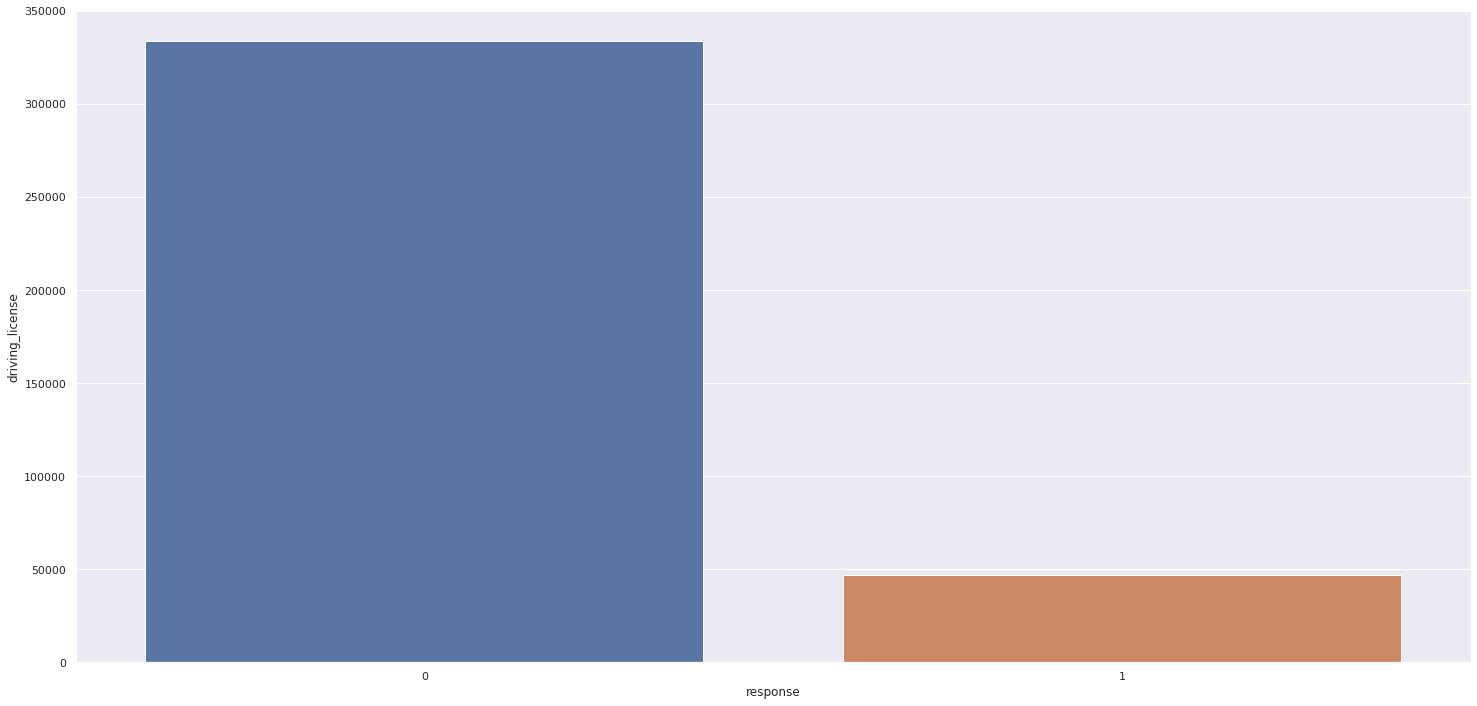

In [24]:
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
sns.barplot(x='response', y='driving_license', data=aux);

### 4.2.5. region code vs response



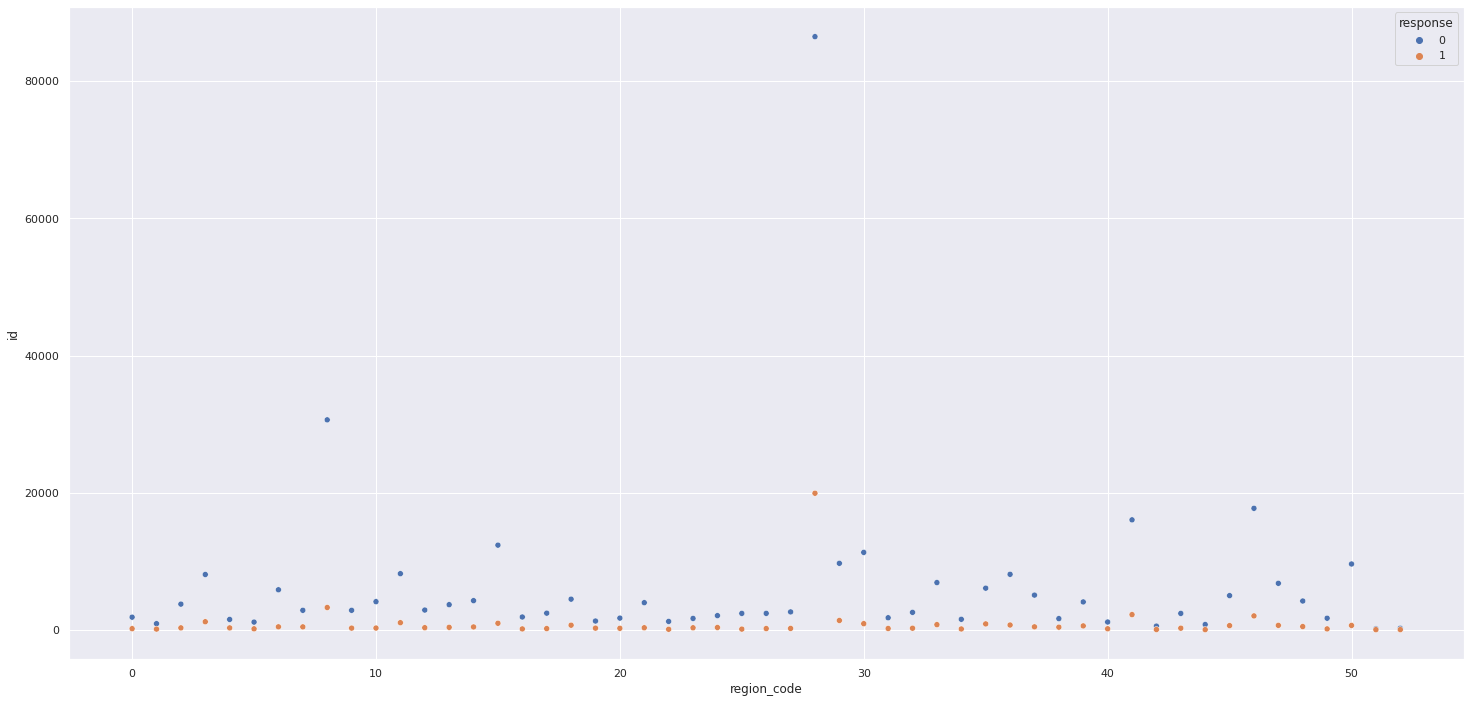

In [25]:
aux = df4[['region_code', 'id', 'response']].groupby(['region_code', 'response']).count().reset_index()

sns.scatterplot(x='region_code', y='id', hue='response', data=aux);

### 4.2.6. Previously Insured vs response



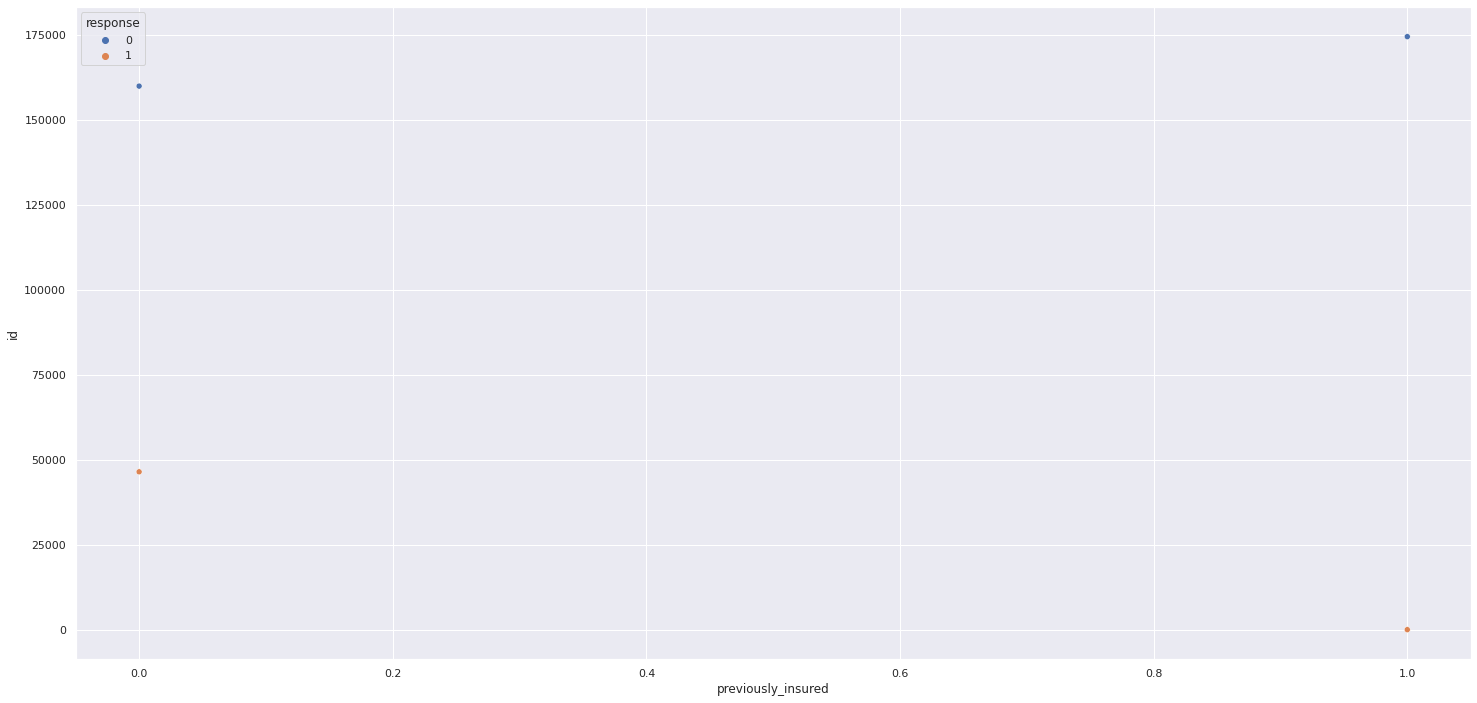

In [26]:
aux = df4[['previously_insured', 'response', 'id']].groupby(['response', 'previously_insured']).count().reset_index()

sns.scatterplot(x='previously_insured', y='id', hue='response', data=aux);

### 4.2.7. Vehicle  vs response



In [27]:
aux = df4[['vehicle_age', 'id', 'response']].groupby(['vehicle_age', 'response']).count().reset_index()
aux

,vehicle_age,response,id
0,bellow_1_year,0,157584
1,bellow_1_year,1,7202
2,between_1_2_years,0,165510
3,between_1_2_years,1,34806
4,over_2_year,0,11305
5,over_2_year,1,4702


### 4.2.8. Vehicle Damage  vs response



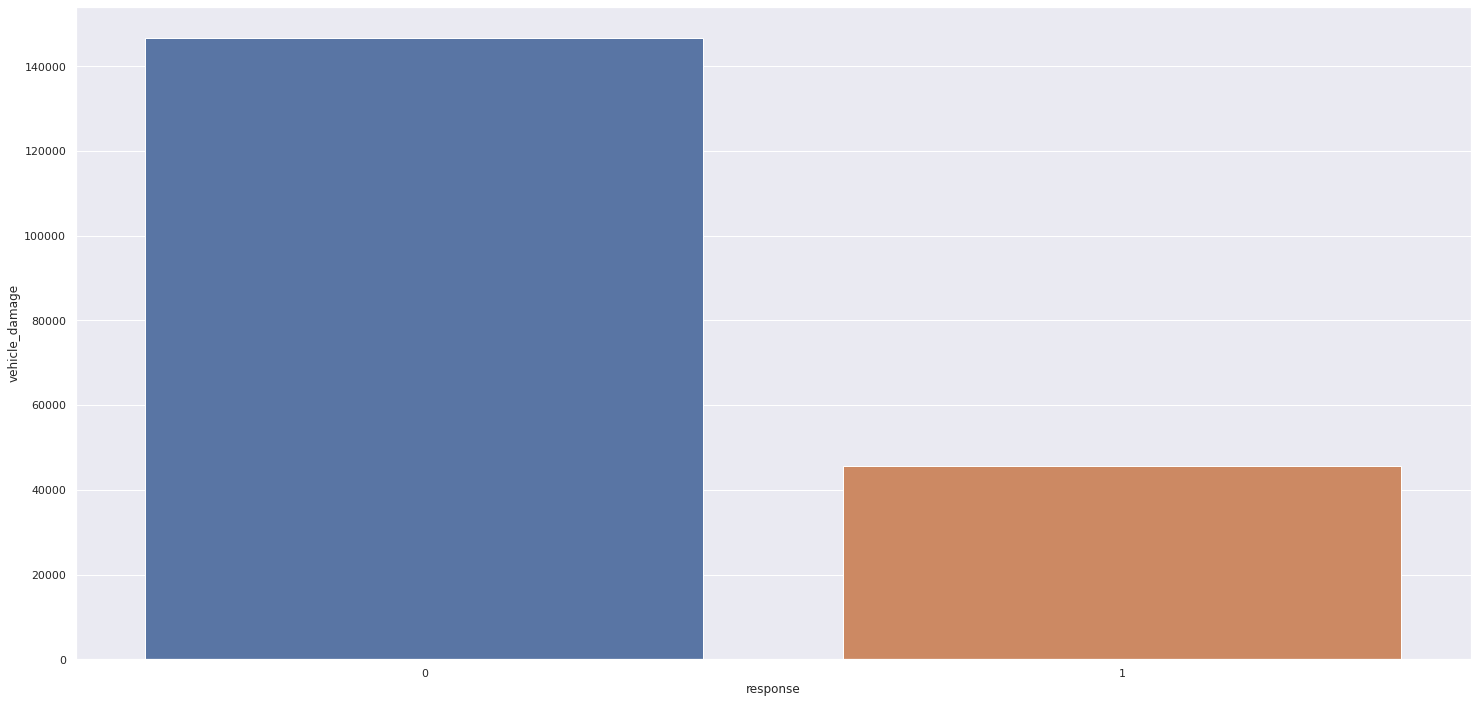

In [28]:
aux = df4[['vehicle_damage', 'response']].groupby('response').sum().reset_index()
sns.barplot(x='response', y='vehicle_damage', data=aux);

### 4.2.9. Policy Sales Channel  vs response



### 4.2.10. Vintage vs response



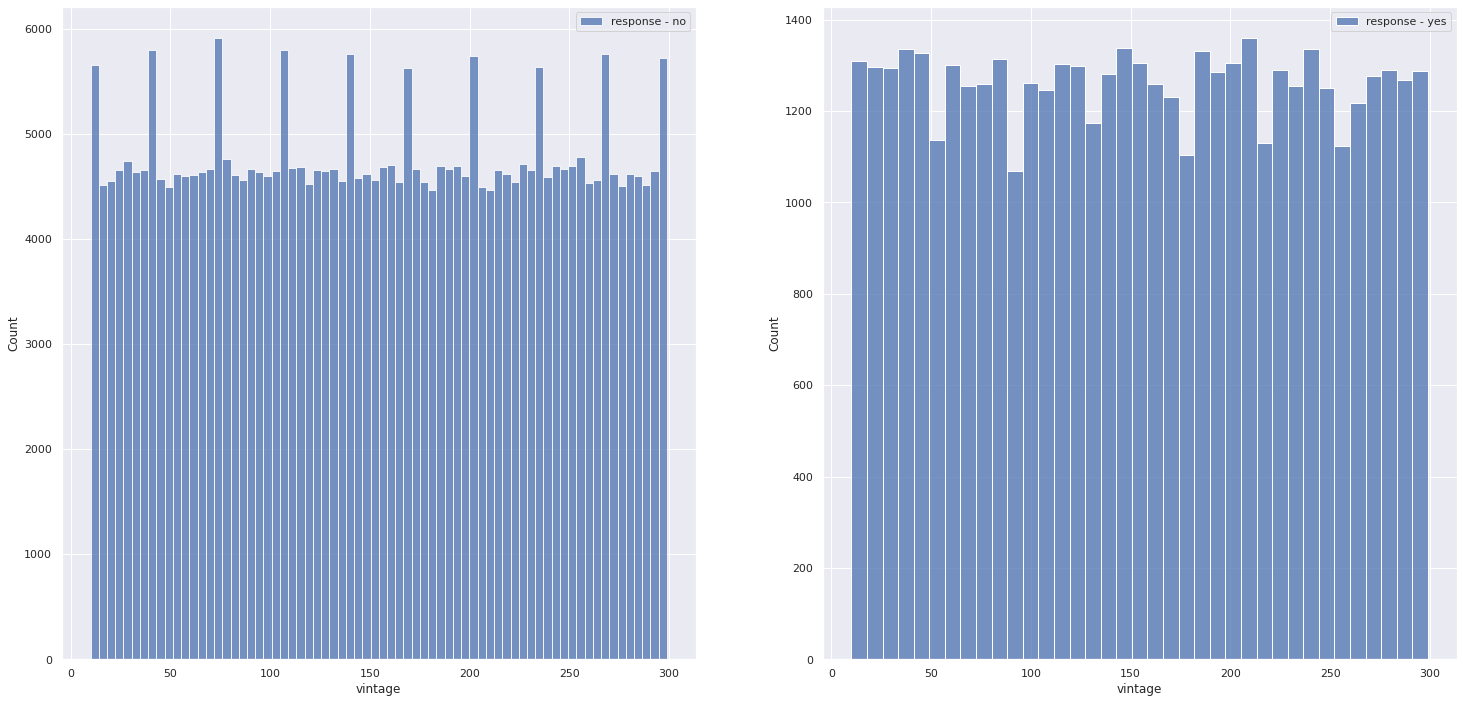

In [38]:
aux1 = df4.loc[df4['response'] == 0, 'vintage']
plt.subplot(1,2,1)
sns.histplot(aux1, label='response - no')
plt.legend()



aux2 = df4.loc[df4['response'] == 1, 'vintage']
plt.subplot(1,2,2)
sns.histplot(aux2, label='response - yes')
plt.legend()

# 5.0. Data Preparation

In [18]:
X = df4.drop(['response', 'id'], axis=1).copy()
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.2)

df5 = pd.concat([x_train, y_train], axis=1)

## 5.1. Standardization

## 5.2. Rescaling

In [19]:
mms_age = pp.MinMaxScaler()
df5['age'] = mms_age.fit_transform(df5[['age']].values)

mms_annual_premium = pp.MinMaxScaler()
df5['annual_premium'] = mms_annual_premium.fit_transform(df5[['annual_premium']].values)

mms_vintage = pp.MinMaxScaler()
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

In [20]:
# pickle.dump(mms_age, open('../src/features/mms_age_scaler.pkl', 'wb'))
# pickle.dump(mms_annual_premium, open('../src/features/mms_annual_premium_scaler.pkl', 'wb'))
# pickle.dump(mms_vintage, open('../src/features/mms_vintage_scaler.pkl', 'wb'))

## 5.3. Encoding

In [21]:
# vehicle_age
df5 = pd.get_dummies(df5, columns=['vehicle_age'], prefix=['vehicle_age'])

# region_code - frequency encode
fe_region_code = df5.groupby('region_code').size() / len(df5)
df5.loc[:, 'region_code'] = df5['region_code'].map(fe_region_code)

# policy_sales_channel
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

In [23]:
# pickle.dump(fe_region_code, open('../src/features/fe_region_code_scaler.pkl', 'wb'))
# pickle.dump(fe_policy_sales_channel, open('../src/features/fe_policy_sales_channel_scaler.pkl', 'wb'))

## 5.4. Data Preparation - Validation 

In [24]:
x_validation['age'] = mms_age.fit_transform(x_validation[['age']].values)

x_validation['annual_premium'] = mms_annual_premium.fit_transform(x_validation[['annual_premium']].values)

x_validation['vintage'] = mms_vintage.fit_transform(x_validation[['vintage']].values)

# vehicle_age
x_validation = pd.get_dummies(x_validation, columns=['vehicle_age'], prefix=['vehicle_age'])

# region_code - frequency encode
x_validation.loc[:, 'region_code'] = x_validation['region_code'].map(fe_region_code)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

<ipython-input-24-4a8a798c4101>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_validation['age'] = mms_age.fit_transform(x_validation[['age']].values)
<ipython-input-24-4a8a798c4101>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_validation['annual_premium'] = mms_annual_premium.fit_transform(x_validation[['annual_premium']].values)
<ipython-input-24-4a8a798c4101>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [64]:
x_validation.fillna(0, inplace=True)

# 6.0. Feature Selection

## 6.1. Boruta as Feature Selection

In [38]:
# x_train_fs = df5.drop('response', axis=1).values
# y_train_fs = df5['response'].values.ravel()

# et = en.ExtraTreesClassifier()

# boruta = BorutaPy(et, verbose=2).fit(x_train_fs, y_train_fs)

## 6.2. Feature Importance

In [65]:
x_train_fs = df5.drop('response', axis=1)
y_train_fs = df5['response'].values

forest = en.RandomForestClassifier().fit(x_train_fs, y_train_fs)

In [66]:
df_importance = pd.DataFrame(data=forest.feature_importances_, index=x_train_fs.columns.tolist()).reset_index()
df_importance.columns = ['feature', 'importance']
df_importance = df_importance.sort_values('importance', ascending=False)

df_importance

,feature,importance
8,vintage,0.283480
6,annual_premium,0.253353
1,age,0.146574
3,region_code,0.097719
5,vehicle_damage,0.071030
7,policy_sales_channel,0.069314
4,previously_insured,0.049383
9,vehicle_age_bellow_1_year,0.011718
0,gender,0.009205
10,vehicle_age_between_1_2_years,0.005604


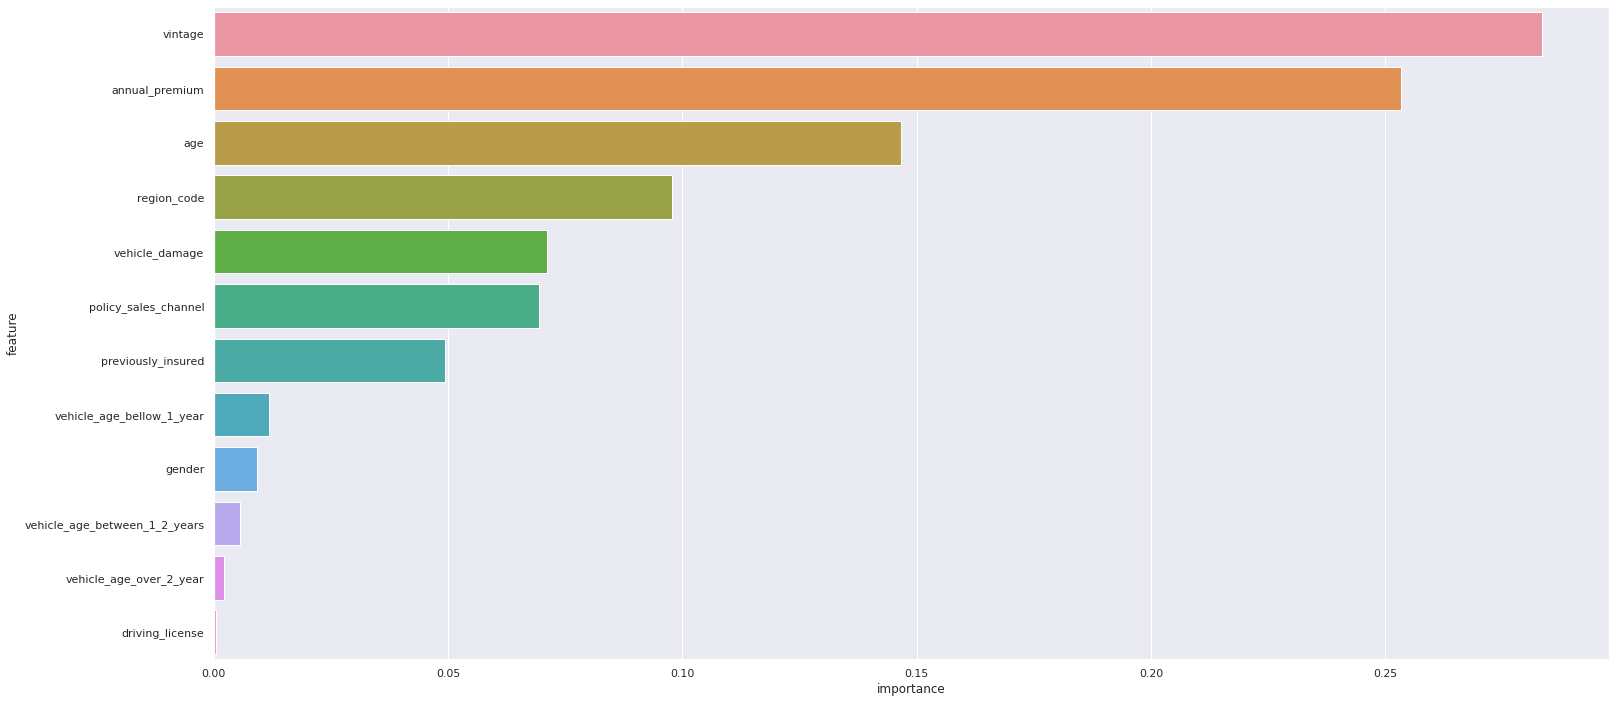

In [67]:
sns.barplot(x='importance', y='feature', data=df_importance);

## 6.3. Manual Selection

In [68]:
cols_selected = ['age', 'region_code', 'previously_insured','vehicle_damage', 'annual_premium',  'policy_sales_channel', 'vintage']

# 7.0. Machine Learning Modelling

In [69]:
x_train = df5[cols_selected]

x_val = x_validation[cols_selected]
y_val = y_validation

## 7.1. KNN

In [70]:
x_val.isna().sum()

age                     0
region_code             0
previously_insured      0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
dtype: int64

In [72]:
# model definition and fit
model_knn = ng.KNeighborsClassifier().fit(x_train, y_train)

# Predictions
yhat_knn = model_knn.predict_proba(x_val)

# Performance
result_knn = perfomance_metrics_at_k(x_val, y_val, yhat_knn, 'KNeighborsClassifier', 0.2)
result_knn

,model_name,Precision@K,Recall@K
0,KNeighborsClassifier,0.29,0.481


## 7.2. Logistic Regression

In [73]:
# model definition and fit
model_lr = lm.LogisticRegression().fit(x_train, y_train)

# predictions
yhat_lr = model_lr.predict_proba(x_val)

# Performance
result_lr = perfomance_metrics_at_k(x_val, y_val, yhat_lr, 'LogisticRegression', 0.2)
result_lr

,model_name,Precision@K,Recall@K
0,LogisticRegression,0.282,0.468


## 7.3. Extra Trees Classifier

In [74]:
# model definition and fit
model_et = en.ExtraTreesClassifier().fit(x_train, y_train)

# predictions
yhat_et = model_et.predict_proba(x_val)

# Perfomance
result_et = perfomance_metrics_at_k(x_val, y_val, yhat_et, 'ExtraTreesClassifier', 0.2 )
result_et

,model_name,Precision@K,Recall@K
0,ExtraTreesClassifier,0.306,0.509


## 7.4. Random Forest Classifier

In [75]:
model_rf = en.RandomForestClassifier().fit(x_train, y_train)

yhat_rf = model_rf.predict_proba(x_val)

result_rf = perfomance_metrics_at_k(x_val, y_val, yhat_rf, 'RandomForestClassifier', 0.2)
result_rf

,model_name,Precision@K,Recall@K
0,RandomForestClassifier,0.315,0.523


## 7.5.  XGBoost Classifier

In [76]:
# model definition and fit
model_xgb = xgb.XGBClassifier().fit(x_train, y_train)

# predictions
yhat_xgb = model_xgb.predict_proba(x_val)

# Perfomance
result_xgb = perfomance_metrics_at_k(x_val, y_val, yhat_xgb, 'XGBClassifier', 0.2)
result_xgb

,model_name,Precision@K,Recall@K
0,XGBClassifier,0.346,0.575


## 7.6. Machine Learning Model's Performance

In [77]:
result = pd.concat([result_knn, result_lr, result_et, result_rf, result_xgb]).sort_values('Recall@K', ascending=False)
result

,model_name,Precision@K,Recall@K
0,XGBClassifier,0.346,0.575
0,RandomForestClassifier,0.315,0.523
0,ExtraTreesClassifier,0.306,0.509
0,KNeighborsClassifier,0.290,0.481
0,LogisticRegression,0.282,0.468


In [81]:
x_val.shape[0] / 5

15244.4